In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Model selection & evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Data Exploration

In [6]:
# Load dataset
df = pd.read_csv("Tech_employee_salary.csv")

#show the data type for each of the attribute
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           5000 non-null   object 
 1   years_experience      5000 non-null   int64  
 2   gender                5000 non-null   object 
 3   education_level       5000 non-null   object 
 4   job_title             5000 non-null   object 
 5   location              5000 non-null   object 
 6   work_mode             5000 non-null   object 
 7   primary_language      5000 non-null   object 
 8   performance_rating    5000 non-null   float64
 9   projects_completed    5000 non-null   int64  
 10  team_size             5000 non-null   int64  
 11  overtime_hours_month  5000 non-null   int64  
 12  certifications_count  5000 non-null   int64  
 13  github_contributions  5000 non-null   int64  
 14  birth_month           5000 non-null   object 
 15  bonus_percentage     

In [7]:
# Show the null value for each of the attribute
print(df.isnull().sum())

employee_id               0
years_experience          0
gender                    0
education_level           0
job_title                 0
location                  0
work_mode                 0
primary_language          0
performance_rating        0
projects_completed        0
team_size                 0
overtime_hours_month      0
certifications_count      0
github_contributions      0
birth_month               0
bonus_percentage        403
stock_options           201
remote_work_days         89
satisfaction_score      254
salary_category           0
dtype: int64


salary_category
Medium    2810
Low       1387
High       803
Name: count, dtype: int64

Medium:  56.2
Low:  27.74
High:  16.06


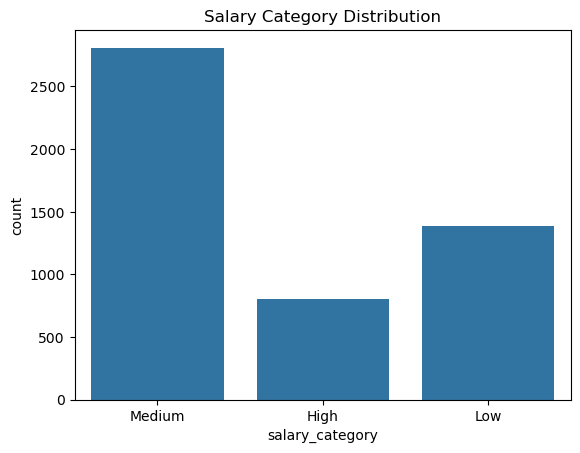

In [8]:
# Overview of Target Class Distribution
print(df['salary_category'].value_counts())
# Percentage Low, Medium and High
print("\nMedium: ",2810/5000*100)
print("Low: ",1387/5000*100)
print("High: ",803/5000*100)
sns.countplot(data=df, x='salary_category')
plt.title('Salary Category Distribution')
plt.show()

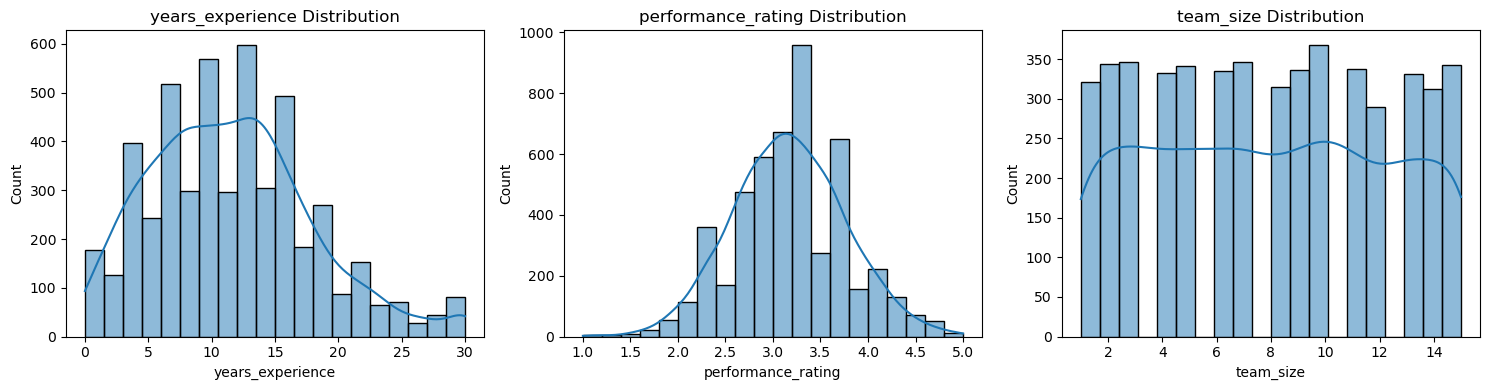

In [9]:
# List of numerical features you want to plot
features = ['years_experience', 'performance_rating', 'team_size']

# Plot histograms
plt.figure(figsize=(15, 4))

for i, col in enumerate(features):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Data Preprocessing

In [10]:
# 1. Drop irrelevant column
df = df.drop(columns=["employee_id"])

# 2. Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

# 3. Handle missing values
# Fill numerical missing values with median
num_imputer = SimpleImputer(strategy="median")
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# Fill categorical missing values with mode
cat_imputer = SimpleImputer(strategy="most_frequent")
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# 4. Clean categorical values (strip spaces, lower case)
for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

# 5. Encode categorical variables
# OneHot for nominal categorical features
nominal_cols = ["gender", "job_title", "location", "work_mode", 
                "primary_language", "stock_options", "birth_month"]

df = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)

# LabelEncoder for ordinal categorical features
ordinal_cols = ["education_level"]
label_encoders = {}

for col in ordinal_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Encode target variable (salary_category)
le_target = LabelEncoder()
df["salary_category_encoded"] = le_target.fit_transform(df["salary_category"])

# Drop original target column (keep encoded version only)
df = df.drop(columns=["salary_category"])

# 6. Standardize numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# 7. Split data into features (X) and target (y)
X = df.drop(columns=["salary_category_encoded"])  # Features
y = df["salary_category_encoded"]  # Target

# 8. Stratified sampling to split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # Stratified sampling to maintain class distribution
)

# Final check
print("Final dataset shape:", df.shape)
print("\nData types after preprocessing:")
print(df.dtypes)
print("\nSample of preprocessed dataset:")
print(df.head())

Final dataset shape: (5000, 61)

Data types after preprocessing:
years_experience           float64
education_level              int64
performance_rating         float64
projects_completed         float64
team_size                  float64
                            ...   
birth_month_may              int64
birth_month_november         int64
birth_month_october          int64
birth_month_september        int64
salary_category_encoded      int64
Length: 61, dtype: object

Sample of preprocessed dataset:
   years_experience  education_level  performance_rating  projects_completed  \
0         -0.076358                3            0.056598           -0.345901   
1          1.338264                0            1.560093            1.211830   
2          1.495444                0            1.225983            1.495054   
3         -0.705079                3            0.223653           -0.629125   
4         -0.233538                0            0.724818           -0.912349   

   team_si

# Model Training for Random Forest

5-Fold Cross-validation Accuracy: 0.7748 ± 0.0112
Accuracy on Test Set: 0.7790

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.54      0.67       161
           1       0.80      0.69      0.74       277
           2       0.76      0.89      0.82       562

    accuracy                           0.78      1000
   macro avg       0.81      0.71      0.74      1000
weighted avg       0.79      0.78      0.77      1000



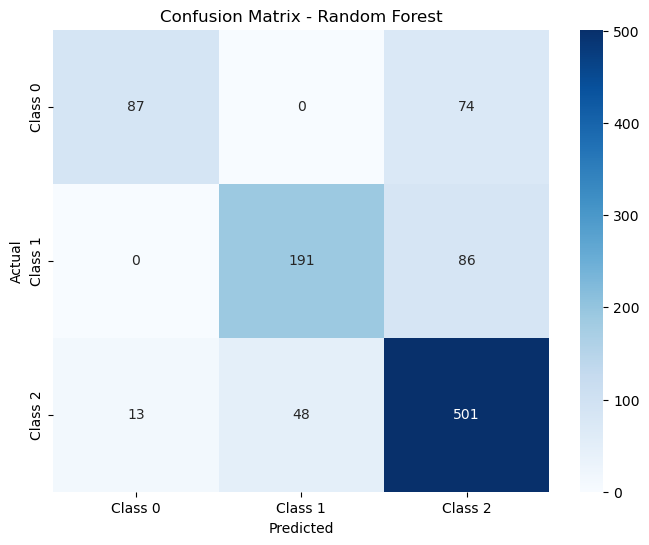

In [40]:
# 1. Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# ------------------------------
# 2. Cross-validation on training set
# ------------------------------
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"5-Fold Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 3. Train the model on the whole training set (as cross-validation is already done)
rf_model.fit(X_train, y_train)

# 4. Make predictions on the test set
y_pred = rf_model.predict(X_test)

# 5. Evaluate the model

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")

# Classification report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualizing the confusion matrix using Seaborn's heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Model Tuning for Random Forest

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters found by GridSearchCV: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Accuracy (CV Mean): 0.7845

Best Model Accuracy on Test Set: 0.7870

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       161
           1       0.78      0.75      0.76       277
           2       0.79      0.84      0.82       562

    accuracy                           0.79      1000
   macro avg       0.78      0.75      0.76      1000
weighted avg       0.79      0.79      0.79      1000



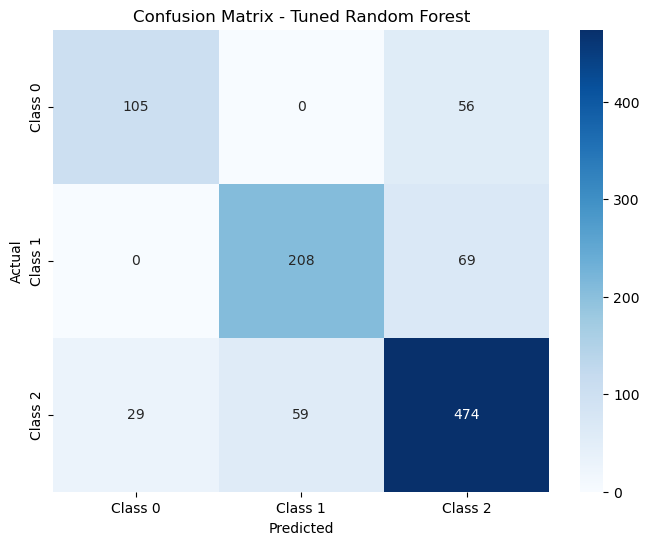

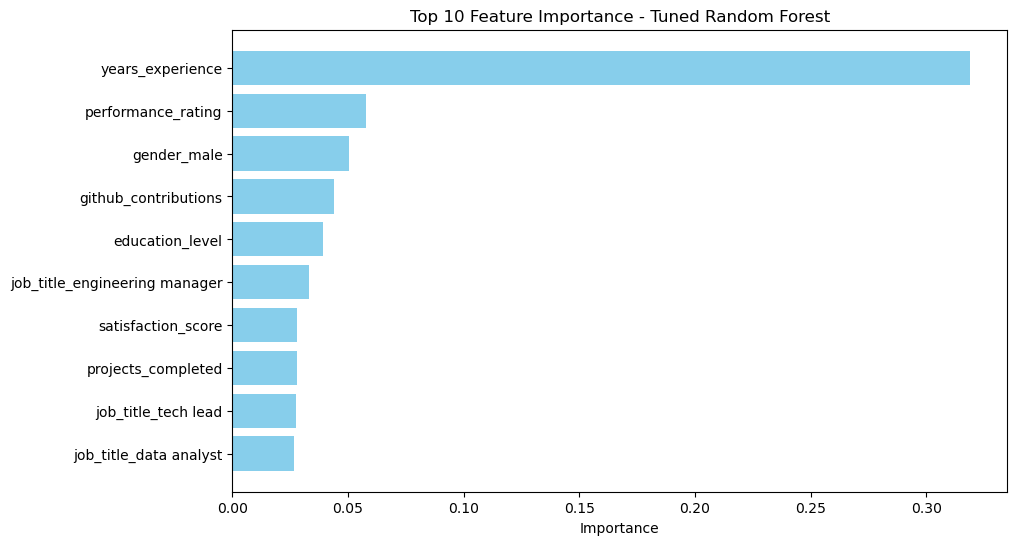

In [81]:
# ------------------------------
# 1. Define hyperparameter grid for tuning
# ------------------------------
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [10, 20, None],      # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],    # Minimum samples at leaf node
    'max_features': ['sqrt', 'log2', None]  # Features to consider for splitting
}

# ------------------------------
# 2. Initialize GridSearchCV with Random Forest
# ------------------------------
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),  # The base RandomForest model
    param_grid=param_grid,  # The hyperparameter grid to search
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all CPU cores
    verbose=2  # Display detailed output of the grid search
)

# ------------------------------
# 3. Fit the model using GridSearchCV
# ------------------------------
grid_search.fit(X_train, y_train)

# ------------------------------
# 4. Get the best hyperparameters
# ------------------------------
print("Best Hyperparameters found by GridSearchCV:", grid_search.best_params_)

print("Best Cross-Validation Accuracy (CV Mean):", round(grid_search.best_score_, 4))

# ------------------------------
# 5. Train the best model
# ------------------------------
best_rf_model = grid_search.best_estimator_

# ------------------------------
# 6. Evaluate the best model
# ------------------------------
y_pred_best = best_rf_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"\nBest Model Accuracy on Test Set: {accuracy_best:.4f}")

# Classification Report for the tuned model
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best))

# ------------------------------
# 7. Confusion Matrix for the best model
# ------------------------------
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

# Visualizing the confusion matrix for the tuned model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ------------------------------
# 8. Feature Importance for the best model
# ------------------------------
importances_best = best_rf_model.feature_importances_
feature_importance_df_best = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances_best
}).sort_values(by="Importance", ascending=False)

# Visualizing the top 10 most important features for the best model
top_10_features_best = feature_importance_df_best.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_10_features_best['Feature'], top_10_features_best['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Top 10 Feature Importance - Tuned Random Forest")
plt.gca().invert_yaxis()  # Most important feature at the top
plt.show()

# Model Training for Logistic Regression

5-Fold Cross-validation Accuracy: 0.8358 ± 0.0215
Logistic Regression Test Accuracy: 0.8030

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.84      0.68      0.75       161
           1       0.79      0.75      0.77       277
           2       0.80      0.86      0.83       562

    accuracy                           0.80      1000
   macro avg       0.81      0.77      0.78      1000
weighted avg       0.80      0.80      0.80      1000



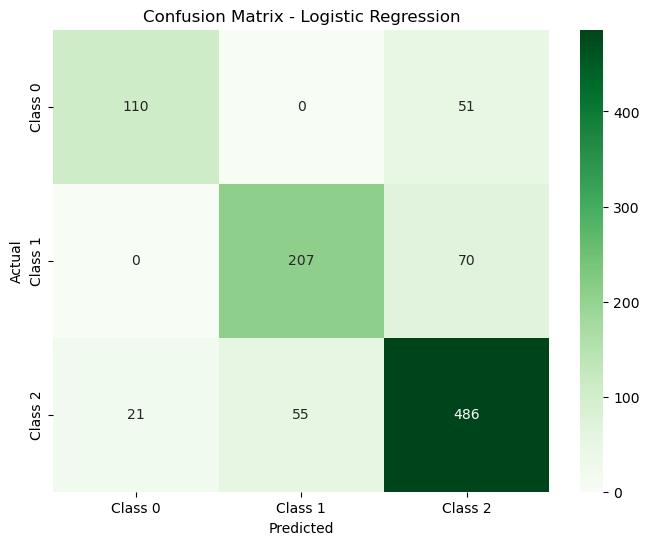

In [79]:
# Ignore FutureWarning for clean output
warnings.filterwarnings('ignore', category=FutureWarning)

# ------------------------------
# 1. Initialize Logistic Regression
# ------------------------------
logreg_model = LogisticRegression(
    solver='lbfgs',             # Efficient solver for multi-class
    max_iter=1000,              # Ensure convergence
    random_state=42
)

# ------------------------------
# 2. Train the model
# ------------------------------
logreg_model.fit(X_train, y_train)

# ------------------------------
# 3. Predict on test set
# ------------------------------
y_pred_logreg = logreg_model.predict(X_test)

# ------------------------------
# 4. Cross-validation to mitigate overfitting
# ------------------------------
cv_scores = cross_val_score(logreg_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"5-Fold Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# ------------------------------
# 5. Evaluate the model
# ------------------------------
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Test Accuracy: {accuracy_logreg:.4f}\n")

print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg))

# ------------------------------
# 6. Confusion Matrix for Logistic Regression
# ------------------------------
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Model Tuning for Logistic Regression

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Best Hyperparameters: {'C': 1000, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Best CV Mean Accuracy: 0.8378

Final Test Accuracy: 0.8100

Final Classification Report (Test):
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       161
           1       0.78      0.78      0.78       277
           2       0.82      0.85      0.83       562

    accuracy                           0.81      1000
   macro avg       0.81      0.79      0.80      1000
weighted avg       0.81      0.81      0.81      1000

Confusion matrix total: 1000


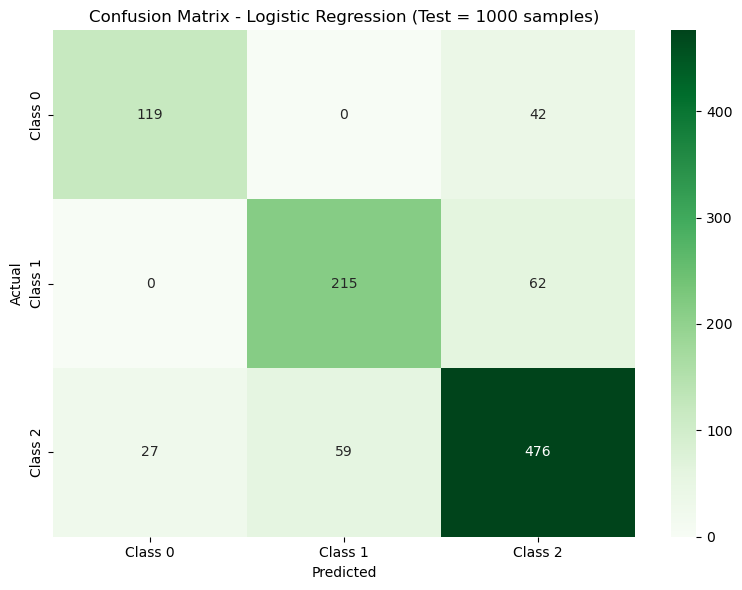

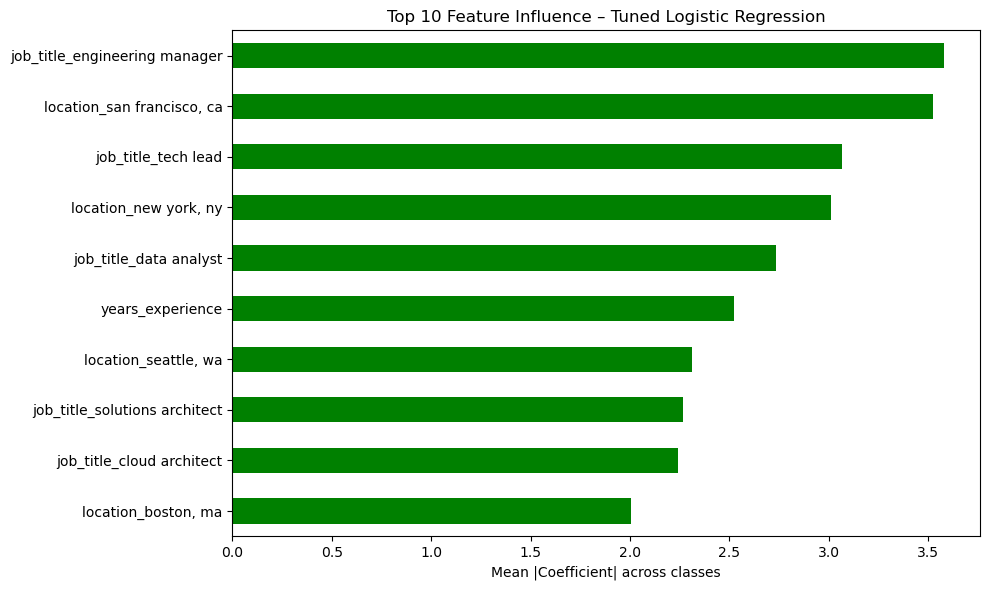

In [76]:
n_total = len(X)
assert n_total >= 1000, "Dataset must have at least 1000 rows to allocate 1000 to test."
test_ratio = 1000 / n_total  # exact fraction to get 1000 samples

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_ratio,
    stratify=y,
    random_state=42
)

# --- 1) Hyperparameter tuning with GridSearchCV using StratifiedKFold (TRAIN ONLY) ---
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [500, 1000, 1500, 2000],
    'fit_intercept': [True, False]
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV Mean Accuracy:", round(grid_search.best_score_, 4))

# --- 2) Train best model on TRAIN ---
best_logreg = grid_search.best_estimator_
best_logreg.fit(X_train, y_train)

# --- 3) Evaluate on the 1000-row TEST set ---
y_pred = best_logreg.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print("\nFinal Classification Report (Test):")
print(classification_report(y_test, y_pred))

# --- 4) Confusion Matrix for Logistic Regression (sums to 1000) ---
conf_matrix_logreg = confusion_matrix(y_test, y_pred)
print("Confusion matrix total:", conf_matrix_logreg.sum())  # should be 1000

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Class 0','Class 1','Class 2'],
            yticklabels=['Class 0','Class 1','Class 2'])
plt.title("Confusion Matrix - Logistic Regression (Test = 1000 samples)")
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout(); plt.show()

# --- 5) Top 10 most important features (multiclass: mean |coef| across classes) ---
coef = best_logreg.coef_  # shape: (n_classes, n_features)
coef_abs_mean = np.mean(np.abs(coef), axis=0)
feat_imp = pd.Series(coef_abs_mean, index=X.columns).sort_values(ascending=False)
top_10 = feat_imp.head(10)

plt.figure(figsize=(10, 6))
top_10.sort_values().plot(kind='barh', color='green')
plt.xlabel("Mean |Coefficient| across classes")
plt.title("Top 10 Feature Influence – Tuned Logistic Regression")
plt.tight_layout(); plt.show()


# Model Training for Decision Tree

Decision Tree Cross-Validation Accuracy: 0.6895 (±0.0160)

Test Accuracy: 0.729

Classification Report (Baseline):
              precision    recall  f1-score   support

        high       0.66      0.68      0.67       161
         low       0.70      0.72      0.71       277
      medium       0.77      0.75      0.76       562

    accuracy                           0.73      1000
   macro avg       0.71      0.72      0.71      1000
weighted avg       0.73      0.73      0.73      1000



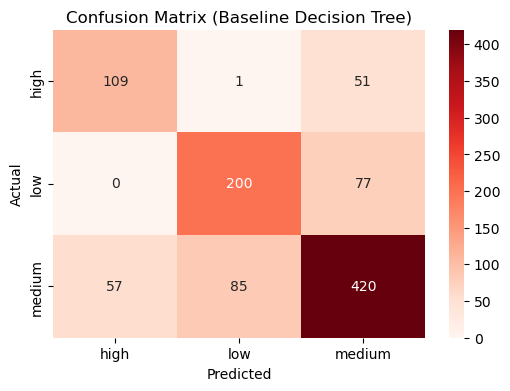

In [44]:
# ================================
# DECISION TREE - BASELINE TRAINING
# ================================
# Initialize Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)

# 1. Cross-validation accuracy
cv_scores = cross_val_score(dt_clf, X_train, y_train, cv=5, scoring="accuracy")
print(f"Decision Tree Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# 2. Train on full training set
dt_clf.fit(X_train, y_train)

# 3. Accuracy on test set
y_pred = dt_clf.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))

# 4. Classification report
print("\nClassification Report (Baseline):")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

# 5. Confusion matrix (colored)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title("Confusion Matrix (Baseline Decision Tree)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Model Tuning for Decision Tree

Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Cross-Validation Accuracy (CV Mean): 0.7315

Tuned Test Accuracy: 0.741

Classification Report (Tuned):
              precision    recall  f1-score   support

        high       0.71      0.66      0.68       161
         low       0.69      0.74      0.72       277
      medium       0.77      0.77      0.77       562

    accuracy                           0.74      1000
   macro avg       0.73      0.72      0.72      1000
weighted avg       0.74      0.74      0.74      1000



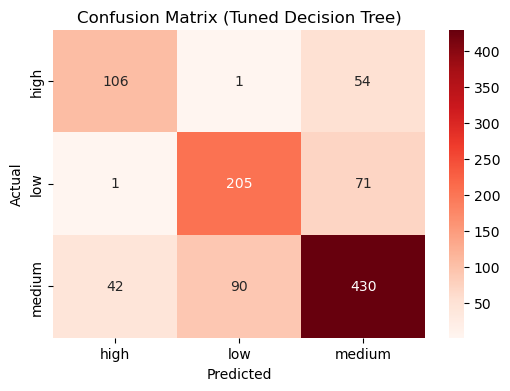

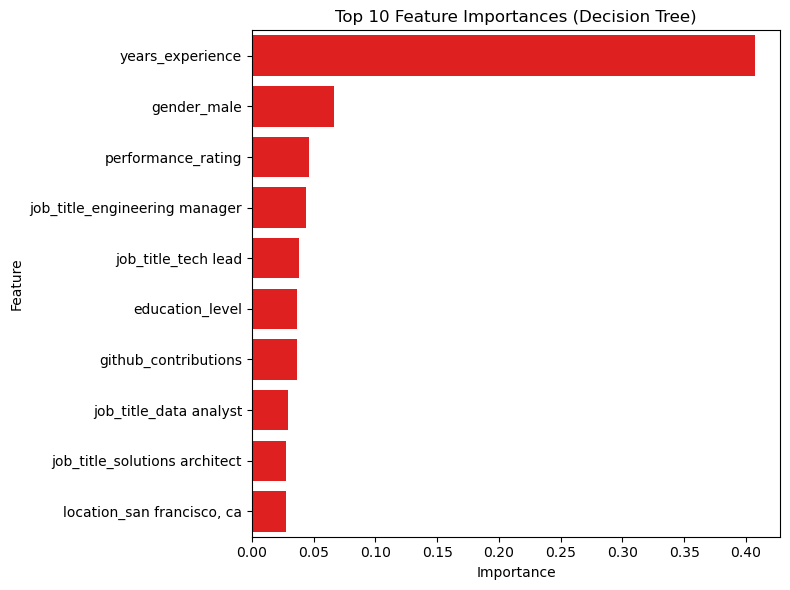

In [17]:
#decision tree tuning
from sklearn.model_selection import GridSearchCV

# ================================
# DECISION TREE - HYPERPARAMETER TUNING
# ================================
# Define parameter grid
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

# Run GridSearchCV
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("\nBest Hyperparameters:", grid_search.best_params_)

print("Best Cross-Validation Accuracy (CV Mean):", round(grid_search.best_score_, 4))

# Evaluate best model
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test)

# Accuracy
print("\nTuned Test Accuracy:", accuracy_score(y_test, y_pred_best))

# Classification report
print("\nClassification Report (Tuned):")
print(classification_report(y_test, y_pred_best, target_names=le_target.classes_))

# Confusion matrix (colored)
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Reds",
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title("Confusion Matrix (Tuned Decision Tree)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ================================
# FEATURE IMPORTANCE
# ================================
# Get feature importance from best model
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_dt.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Top 10 features
top10 = feature_importance.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=top10, color="red")
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()

# Model Training for Support Vector Machine (SVM)

SVM Cross-Validation Accuracy: 0.8397 (±0.0221)
SVM Test Accuracy: 0.808

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76       161
           1       0.80      0.76      0.78       277
           2       0.81      0.86      0.83       562

    accuracy                           0.81      1000
   macro avg       0.81      0.78      0.79      1000
weighted avg       0.81      0.81      0.81      1000



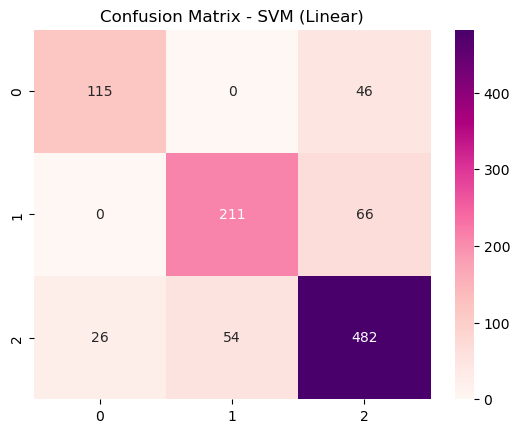

In [11]:
# Initialize the Support Vector Machine(SVM) model
svm_model = SVC(kernel='linear', random_state=42)

# Cross-validation on training set
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"SVM Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Model training
svm_model.fit(X_train, y_train)

# Make a predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu')
plt.title("Confusion Matrix - SVM (Linear)")
plt.show()

# Model Tuning for SVM

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best CV score for SVM: 0.8405000000000001


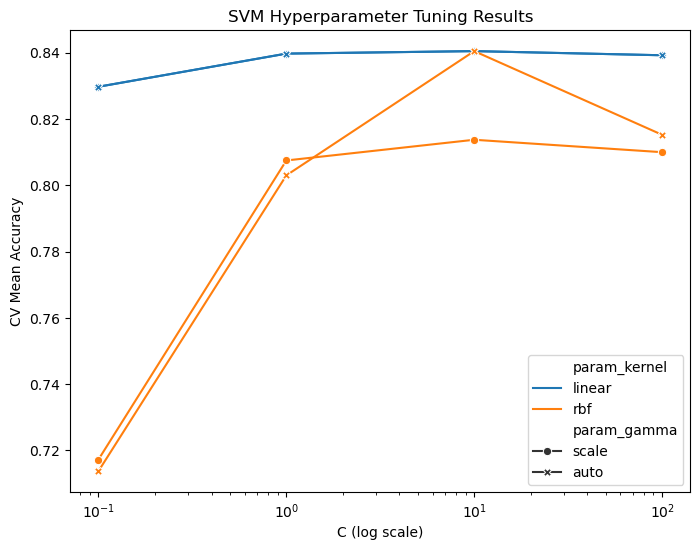

=== Best SVM Test Performance ===
Accuracy: 0.804

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76       161
           1       0.79      0.75      0.77       277
           2       0.81      0.86      0.83       562

    accuracy                           0.80      1000
   macro avg       0.80      0.77      0.79      1000
weighted avg       0.80      0.80      0.80      1000



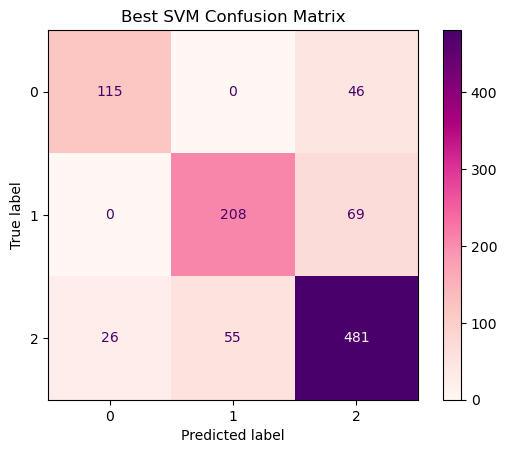

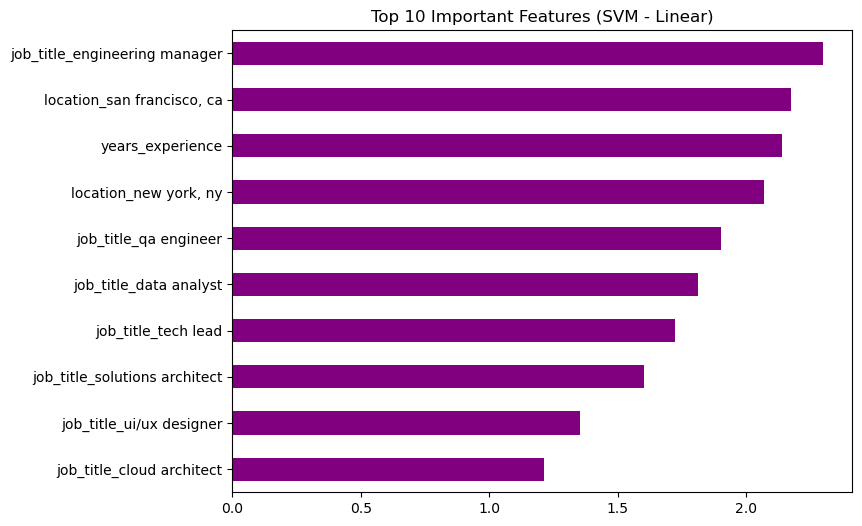

In [12]:
# 1. Define parameter space
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

# 2. GridSearchCV tuning
grid_svm = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_svm.fit(X_train, y_train)

print("Best parameters for SVM:", grid_svm.best_params_)
print("Best CV score for SVM:", grid_svm.best_score_)

# 3. Analyze the impact of parameter combinations
cv_results = pd.DataFrame(grid_svm.cv_results_)

# Visualization of parameter effects
plt.figure(figsize=(8,6))
sns.lineplot(data=cv_results, x="param_C", y="mean_test_score",
             hue="param_kernel", style="param_gamma", markers=True, dashes=False)
plt.xscale("log")
plt.title("SVM Hyperparameter Tuning Results")
plt.ylabel("CV Mean Accuracy")
plt.xlabel("C (log scale)")
plt.show()

# 4. Evaluate the best model on the test set
best_svm = grid_svm.best_estimator_
y_pred_best = best_svm.predict(X_test)

print("=== Best SVM Test Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(confusion_matrix=cm_best).plot(cmap="RdPu")
plt.title("Best SVM Confusion Matrix")
plt.show()

# 5. Feature importance analysis
if grid_svm.best_params_['kernel'] == 'linear':
    # Linear kernel: use coef_
    coef = best_svm.coef_.toarray()[0] if hasattr(best_svm.coef_, "toarray") else best_svm.coef_[0]
    feat_imp = pd.Series(coef, index=X.columns).abs().sort_values(ascending=False)

    feat_imp.head(10).plot(kind='barh', figsize=(8,6), color="purple")
    plt.gca().invert_yaxis()
    plt.title("Top 10 Important Features (SVM - Linear)")
    plt.show()
else:
    # Nonlinear kernel (RBF): use permutation importance
    perm = permutation_importance(best_svm, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    feat_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

    feat_imp.head(10).plot(kind='barh', figsize=(8,6), color="purple")
    plt.gca().invert_yaxis()
    plt.title("Top 10 Important Features (SVM - RBF)")
    plt.show()

# Model Training for K-Nearest Neighbours (KNN)

KNN Cross-Validation Accuracy: 0.6672 (±0.0144)
KNN Test Accuracy: 0.659

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.37      0.45       161
           1       0.65      0.64      0.64       277
           2       0.68      0.75      0.72       562

    accuracy                           0.66      1000
   macro avg       0.63      0.59      0.60      1000
weighted avg       0.65      0.66      0.65      1000



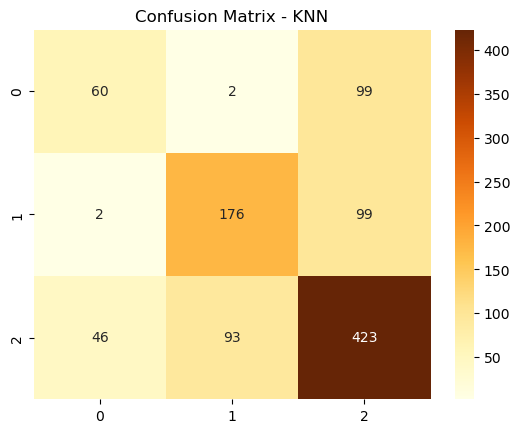

In [48]:
# Initialize KNN
knn_model = KNeighborsClassifier(n_neighbors=5)

# Cross-validation
cv_scores_knn = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"KNN Cross-Validation Accuracy: {cv_scores_knn.mean():.4f} (±{cv_scores_knn.std():.4f})")

# Train the model
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test)

# Evaluation
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

# Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='YlOrBr')
plt.title("Confusion Matrix - KNN")
plt.show()

# Model Tuning for KNN

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 31, 'weights': 'uniform'}
Best CV score for KNN: 0.7275


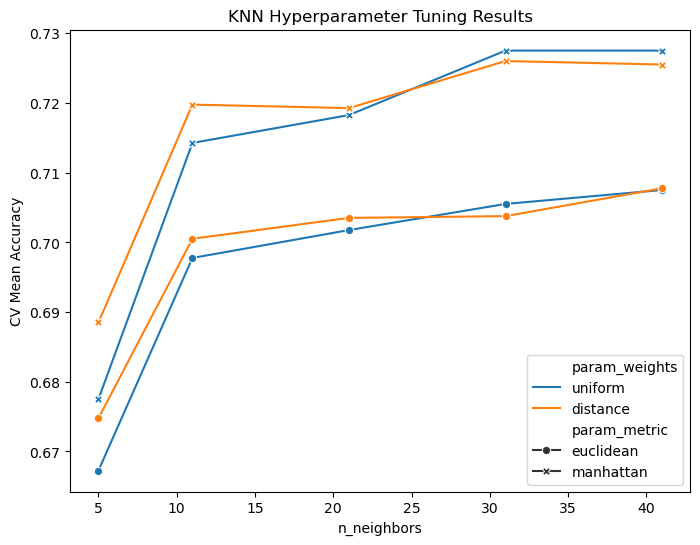

=== Best KNN Test Performance ===
Accuracy: 0.731

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.38      0.54       161
           1       0.75      0.61      0.67       277
           2       0.71      0.89      0.79       562

    accuracy                           0.73      1000
   macro avg       0.79      0.63      0.67      1000
weighted avg       0.75      0.73      0.72      1000



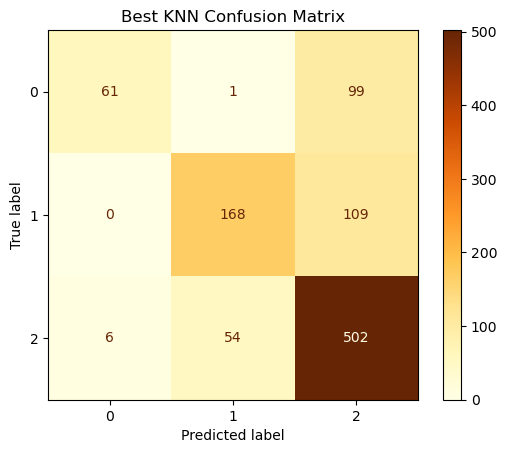

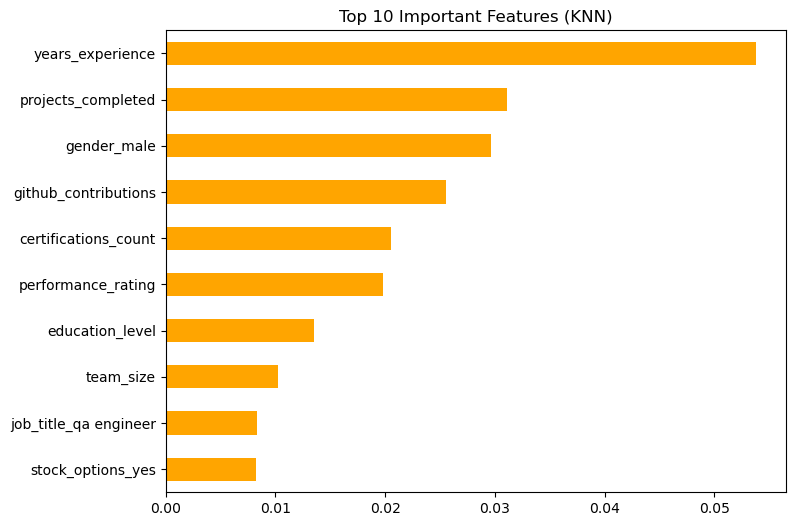

In [22]:
# 1. Define parameter search space
param_grid_knn = {
    'n_neighbors': [5, 11, 21, 31, 41],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# 2. GridSearchCV tuning
grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_knn.fit(X_train, y_train)

print("Best parameters for KNN:", grid_knn.best_params_)
print("Best CV score for KNN:", grid_knn.best_score_)

# 3. Analyze the impact of parameter combinations
cv_results = pd.DataFrame(grid_knn.cv_results_)

# Visualization of parameter effects
plt.figure(figsize=(8,6))
sns.lineplot(data=cv_results, x="param_n_neighbors", y="mean_test_score",
             hue="param_weights", style="param_metric", markers=True, dashes=False)
plt.title("KNN Hyperparameter Tuning Results")
plt.ylabel("CV Mean Accuracy")
plt.xlabel("n_neighbors")
plt.show()

# 4. Evaluate the best model on the test set
best_knn = grid_knn.best_estimator_
y_pred_best = best_knn.predict(X_test)

print("=== Best KNN Test Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(confusion_matrix=cm_best).plot(cmap="YlOrBr")
plt.title("Best KNN Confusion Matrix")
plt.show()

# 5. Feature importance (Permutation Importance)
perm = permutation_importance(best_knn, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
feat_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

# Visualization of top 10 features
feat_imp.head(10).plot(kind='barh', figsize=(8,6), color="orange")
plt.gca().invert_yaxis()
plt.title("Top 10 Important Features (KNN)")
plt.show()


# Model Performance Comparison by Using Table

In [19]:

# Create a DataFrame with model names, test accuracy, and CV accuracy
model_comparison = pd.DataFrame({
    "Model": [
        "Random Forest (Untuned)",
        "Random Forest (Tuned)",
        "Logistic Regression (Untuned)",
        "Logistic Regression (Tuned)",
        "Decision Tree (Untuned)",
        "Decision Tree (Tuned)",
        "SVM (Untuned)",
        "SVM (Tuned)",
        "KNN (Untuned)",
        "KNN (Tuned)"
    ],
    "Test Accuracy": [
        0.7790,  # rf untuned
        0.7870,  # rf tuned
        0.8030,  # logistic untuned
        0.8100,  # logistic tuned
        0.729,  # decision tree untuned
        0.741,  # decision tree tuned
        0.808,  # svm untuned
        0.804,  # svm tuned
        0.659,  # knn untuned
        0.731   # knn tuned
    ],
    "CV Accuracy (Mean)": [
        0.7748,  # rf untuned
        0.7845,  # rf tuned
        0.8358,  # logistic untuned
        0.8378, # logistic tuned
        0.6895,  # decision tree untuned
        0.7315,  # decision tree tuned
        0.8397,  # svm untuned
        0.8405,  # svm tuned
        0.6672,  # knn untuned
        0.7275   # knn tuned
    ]
})

# Display the table
print("\n=== Model Performance Comparison ===")
display(model_comparison)



=== Model Performance Comparison ===


,Model,Test Accuracy,CV Accuracy (Mean)
0,Random Forest (Untuned),0.779,0.7748
1,Random Forest (Tuned),0.787,0.7845
2,Logistic Regression (Untuned),0.803,0.8358
3,Logistic Regression (Tuned),0.810,0.8378
4,Decision Tree (Untuned),0.729,0.6895
5,Decision Tree (Tuned),0.741,0.7315
6,SVM (Untuned),0.808,0.8397
7,SVM (Tuned),0.804,0.8405
8,KNN (Untuned),0.659,0.6672
9,KNN (Tuned),0.731,0.7275


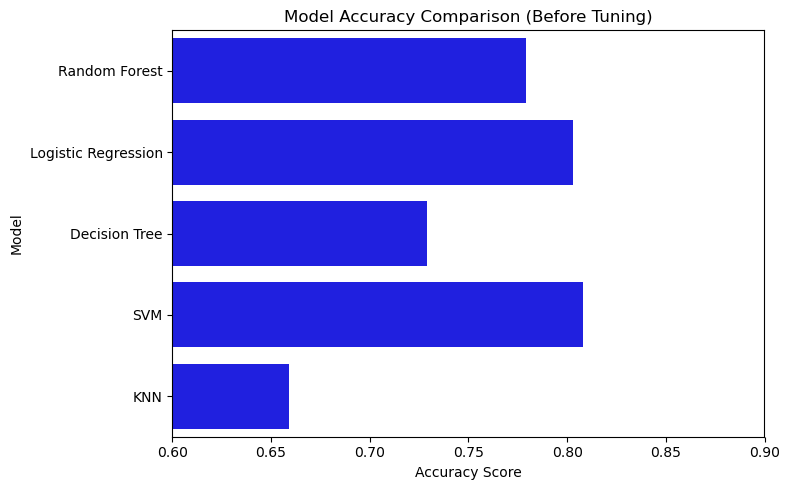

In [20]:
# Model accuracies (before tuning)
model_results = pd.DataFrame([
    {"Model": "Random Forest", "Accuracy": 0.7790},
    {"Model": "Logistic Regression", "Accuracy": 0.8030},
    {"Model": "Decision Tree", "Accuracy": 0.7290},
    {"Model": "SVM", "Accuracy": 0.808},
    {"Model": "KNN", "Accuracy": 0.659}
])

# Plot (original order)
plt.figure(figsize=(8, 5))
sns.barplot(data=model_results,
            x="Accuracy", y="Model", color="blue")
plt.title("Model Accuracy Comparison (Before Tuning)")
plt.xlabel("Accuracy Score")
plt.ylabel("Model")
plt.xlim(0.6, 0.9)
plt.tight_layout()
plt.show()

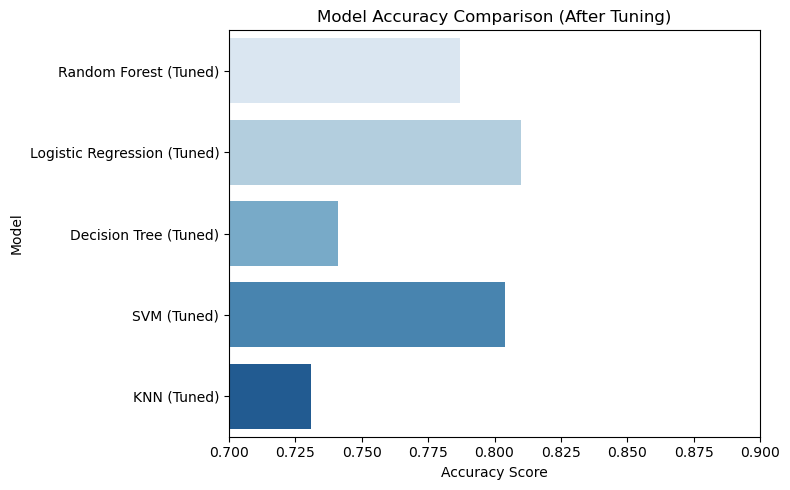

In [21]:
# Tuned model accuracies
tuned_model_results = pd.DataFrame([
    {"Model": "Random Forest (Tuned)", "Accuracy": 0.7870},
    {"Model": "Logistic Regression (Tuned)", "Accuracy": 0.8100},
    {"Model": "Decision Tree (Tuned)", "Accuracy": 0.7410},
    {"Model": "SVM (Tuned)", "Accuracy": 0.8040},
    {"Model": "KNN (Tuned)", "Accuracy": 0.7310}
])

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=tuned_model_results,
            x="Accuracy", y="Model", hue="Model", palette="Blues", legend=False)
plt.title("Model Accuracy Comparison (After Tuning)")
plt.xlabel("Accuracy Score")
plt.ylabel("Model")
plt.xlim(0.7, 0.9)
plt.tight_layout()
plt.show()